# 1. Import packages

In [1]:
import sys
sys.path.append('..')
from modules import preprocess, benchmarking, graphics
import pandas as pd

Invoking __init__.py for modules


# 2. Load dataset

In [2]:
df = preprocess.load_csv_data('../dataset/Occupancy_Estimation.csv')

# 3. Data preprocessing
- Step 1: Transform features
  - Binary results for Room_Occupancy_Count
  - Drop Date and Time features
- Step 2: Clean data
  - Drop duplicated rows

In [3]:
# Step 1: Recode Room_Occupancy_Count column
preprocess.recode_dataset_output(df)

# Step 2: Filter Date and Time columns
preprocess.remove_time_columns(df)

df.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


# 4. Benchmarking

In [4]:
# Split dataset into features and output
X = preprocess.get_features(df)
y = preprocess.get_output(df)

# Split dataset into training and test
X_train, X_test, y_train, y_test = preprocess.split_dataset(X, y)

## Create benchmarking Dataframe:
- Create benchmarking's df structure.
- Track models training with CodeCarbon and Eco2AI.
- Store in benchmarking's df tracking results.
- Store in benchmarking's df evaluation metrics.

In [5]:
df_benchmarking = benchmarking.create_benchmarking(X_train, y_train, X_test, y_test)

[codecarbon INFO @ 18:45:22] [setup] RAM Tracking...
[codecarbon INFO @ 18:45:22] [setup] GPU Tracking...
[codecarbon INFO @ 18:45:22] No GPU found.
[codecarbon INFO @ 18:45:22] [setup] CPU Tracking...
[codecarbon WARNING @ 18:45:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:45:23] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:45:23] >>> Tracker's metadata:
[codecarbon INFO @ 18:45:23]   Platform system: Linux-5.19.0-41-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 18:45:23]   Python version: 3.10.8
[codecarbon INFO @ 18:45:23]   Available RAM : 4.946 GB
[codecarbon INFO @ 18:45:23]   CPU count: 4
[codecarbon INFO @ 18:45:23]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:45:23]   GPU count: None
[codecarbon INFO @ 18:45:23]   GPU model: None


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/misanchz/miniconda3/envs/TFG/lib/python3.10/site-packages/sklearn/linear_model/_l

Best estimator LR:  Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 LogisticRegression(C=1, max_iter=500, penalty='l1',
                                    solver='liblinear'))])
Precision:  0.9965928449744463
Recall:  0.9948979591836735
F1:  0.9957446808510638


[codecarbon INFO @ 18:45:35] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:45:35] >>> Tracker's metadata:
[codecarbon INFO @ 18:45:35]   Platform system: Linux-5.19.0-41-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 18:45:35]   Python version: 3.10.8
[codecarbon INFO @ 18:45:35]   Available RAM : 4.946 GB
[codecarbon INFO @ 18:45:35]   CPU count: 4
[codecarbon INFO @ 18:45:35]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:45:35]   GPU count: None
[codecarbon INFO @ 18:45:35]   GPU model: None


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[codecarbon INFO @ 18:45:53] Energy consumed for RAM : 0.000008 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:45:53] Energy consumed for all CPUs : 0.000136 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:45:53] 0.000143 kWh of electricity used since the begining.
[codecarbon INFO @ 18:46:08] Energy consumed for RAM : 0.000015 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:46:08] Energy consumed for all CPUs : 0.000271 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:46:08] 0.000286 kWh of electricity used since the begining.
[codecarbon INFO @ 18:46:23] Energy consumed for RAM : 0.000023 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:46:23] Energy consumed for all CPUs : 0.000406 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:46:23] 0.000430 kWh of electricity used since the begining.
[codecarbon INFO @ 18:46:23] Energy consumed for RAM : 0.000023 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:46:23] Energy consumed for all

Best estimator RF:  RandomForestClassifier(bootstrap=False, max_depth=110, max_features=3,
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=300)
Precision:  1.0
Recall:  0.9982993197278912
F1:  0.9991489361702128


[codecarbon INFO @ 18:46:25] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:46:25] >>> Tracker's metadata:
[codecarbon INFO @ 18:46:25]   Platform system: Linux-5.19.0-41-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 18:46:25]   Python version: 3.10.8
[codecarbon INFO @ 18:46:25]   Available RAM : 4.946 GB
[codecarbon INFO @ 18:46:25]   CPU count: 4
[codecarbon INFO @ 18:46:25]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:46:25]   GPU count: None
[codecarbon INFO @ 18:46:25]   GPU model: None


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[codecarbon INFO @ 18:46:43] Energy consumed for RAM : 0.000008 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:46:43] Energy consumed for all CPUs : 0.000135 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:46:43] 0.000143 kWh of electricity used since the begining.
[codecarbon INFO @ 18:46:59] Energy consumed for RAM : 0.000016 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:46:59] Energy consumed for all CPUs : 0.000277 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:46:59] 0.000293 kWh of electricity used since the begining.
[codecarbon INFO @ 18:47:14] Energy consumed for RAM : 0.000024 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:47:14] Energy consumed for all CPUs : 0.000412 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:47:14] 0.000436 kWh of electricity used since the begining.
[codecarbon INFO @ 18:47:26] Energy consumed for RAM : 0.000030 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:47:26] Energy consumed for all

Best estimator SVM:  SVC(C=1, gamma=0.001)
Precision:  1.0
Recall:  0.9982993197278912
F1:  0.9991489361702128


[codecarbon INFO @ 18:47:28] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:47:28] >>> Tracker's metadata:
[codecarbon INFO @ 18:47:28]   Platform system: Linux-5.19.0-41-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 18:47:28]   Python version: 3.10.8
[codecarbon INFO @ 18:47:28]   Available RAM : 4.946 GB
[codecarbon INFO @ 18:47:28]   CPU count: 4
[codecarbon INFO @ 18:47:28]   CPU model: Intel(R) Core(TM) i5-9400F CPU @ 2.90GHz
[codecarbon INFO @ 18:47:28]   GPU count: None
[codecarbon INFO @ 18:47:28]   GPU model: None


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[codecarbon INFO @ 18:47:47] Energy consumed for RAM : 0.000008 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:47:47] Energy consumed for all CPUs : 0.000145 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:47:47] 0.000153 kWh of electricity used since the begining.
[codecarbon INFO @ 18:48:02] Energy consumed for RAM : 0.000016 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:48:02] Energy consumed for all CPUs : 0.000280 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:48:02] 0.000296 kWh of electricity used since the begining.
[codecarbon INFO @ 18:48:17] Energy consumed for RAM : 0.000024 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:48:17] Energy consumed for all CPUs : 0.000416 kWh. All CPUs Power : 32.5 W
[codecarbon INFO @ 18:48:17] 0.000439 kWh of electricity used since the begining.
[codecarbon INFO @ 18:48:32] Energy consumed for RAM : 0.000031 kWh. RAM Power : 1.8548598289489746 W
[codecarbon INFO @ 18:48:32] Energy consumed for all

Best estimator MLP:  Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 MLPClassifier(activation='tanh', alpha=0.01,
                               hidden_layer_sizes=(100, 100, 100), max_iter=500,
                               solver='lbfgs'))])
Precision:  0.9966044142614601
Recall:  0.9982993197278912
F1:  0.9974511469838572


In [6]:
df_benchmarking

,Algoritmos,CodeCarbon (kWh),Eco2AI (kWh),Precision,Recall,F Score
0,Logistic Regression,0.000055,0.000034,0.996593,0.994898,0.995745
1,Random Forest,0.000433,0.000181,1.000000,0.998299,0.999149
2,Support Vector Machines,0.000547,0.000222,1.000000,0.998299,0.999149
3,Multilayer Perceptron,0.002629,0.003773,0.996604,0.998299,0.997451


## Save benchmarking's DataFrame in csv file

In [7]:
preprocess.save_in_csv_file(df_benchmarking, 'benchmarking.csv')

## Graphics

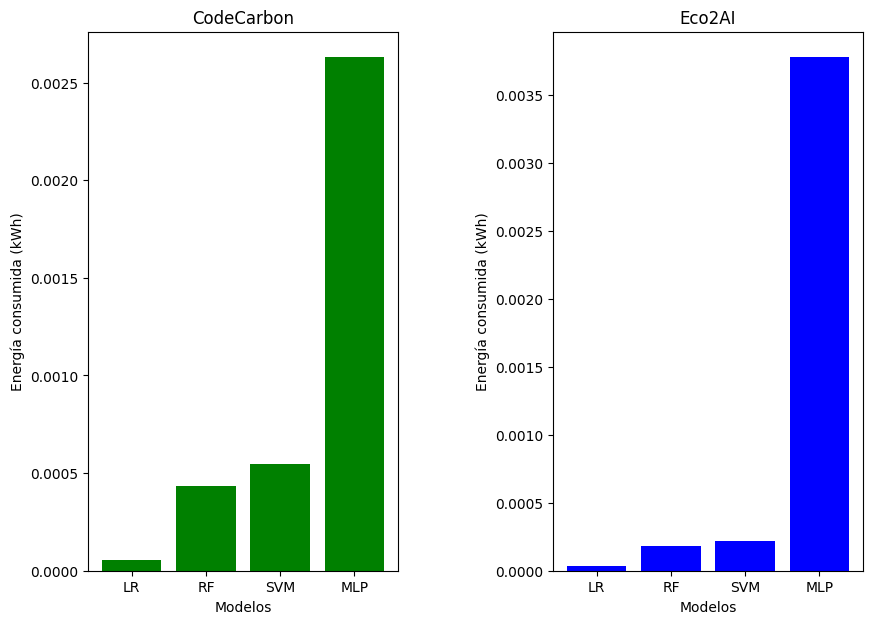

In [3]:
graphics.plot_models_energy_consumed(df_benchmarking)

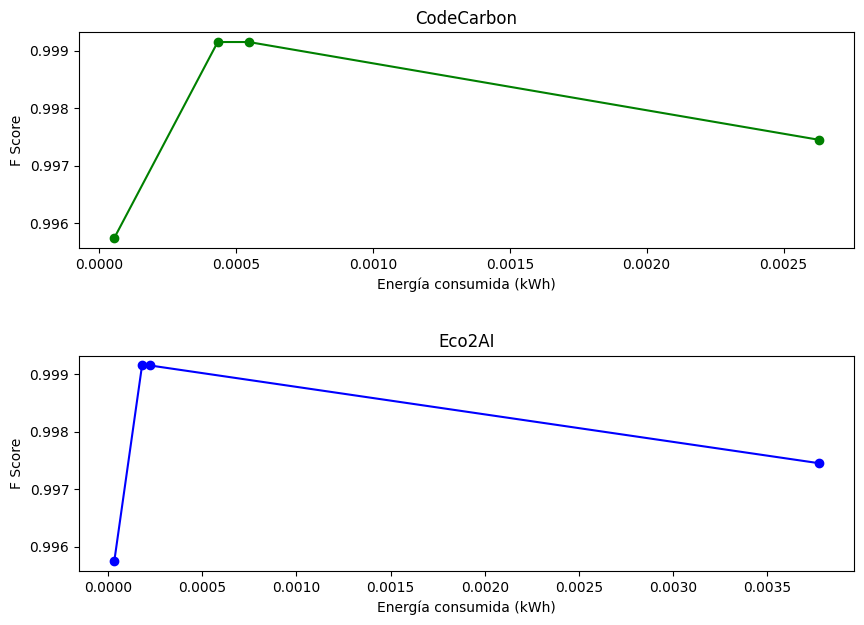

In [4]:
graphics.plot_energy_consumed_and_fscore(df_benchmarking)